# Text classification and sentiment analysis: Twitter

Once text data has been converted into numerical features using the natural language processing techniques discussed in the previous sections, text classification works just like any other classification task.

In this notebook, we will apply these preprocessing technique to news articles, product reviews, and Twitter data and teach various classifiers to predict discrete news categories, review scores, and sentiment polarity.

## Imports

In [1]:
using Pkg

In [2]:
using PyCall
using Conda

In [3]:
#Pkg.add("TextAnalysis")
#Pkg.add("CSV")
#Pkg.add("DataFrames")
#Pkg.add("StatsPlots")
#Pkg.add("Dates")
#Pkg.add("MLJ")
#Pkg.add("MLJText")
#Pkg.add("StringEncodings")
#Pkg.add("ScikitLearn")

In [4]:
using TextAnalysis
using CSV
using DataFrames
using StatsPlots
using Dates
using MLJ
using MLJText
using StringEncodings

In [5]:
using ScikitLearn

In [6]:
using ScikitLearn: @sk_import

In [7]:
@sk_import feature_extraction.text: CountVectorizer
@sk_import feature_extraction.text: TfidfVectorizer
@sk_import naive_bayes: MultinomialNB
@sk_import metrics: roc_auc_score
@sk_import metrics: roc_curve
@sk_import metrics: accuracy_score

PyObject <function accuracy_score at 0x000000007FDB93A0>

## Twitter Sentiment

### Download the data

We use a dataset that contains 1.6 million training and 350 test tweets from 2009 with algorithmically assigned binary positive and negative sentiment scores that are fairly evenly split.

Follow the [instructions](../data/twitter_sentiment.ipynb) to create the dataset.

- 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive); training data has no neutral tweets
- 1 - the id of the tweet (2087)
- 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- 3 - the query (lyx). If there is no query, then this value is NO_QUERY. (only test data uses query)
- 4 - the user that tweeted (robotickilldozr)
- 5 - the text of the tweet (Lyx is cool)

### Read and preprocess train/test data

Take a few preprocessing steps:
- remove tweets above the legal (at the time) length of 140 characters,
- binarize polarity, and 
- move the data to the faster parquet format.

In [8]:
function load_train_data()
    names = ["polarity", "id", "date", "query", "user", "text"]
    f = open("../data/sentiment140/train.csv","r")
    s = StringDecoder(f,"LATIN1", "UTF-8")
    train_df = CSV.read(s, DataFrame; header = names)
    close(s)
    close(f)
    return train_df
end

load_train_data (generic function with 1 method)

In [9]:
function clean_train_df(train_df)
    train_df.date = replace.(train_df.date, " PDT"=>"")
    train_df.date = DateTime.(train_df.date, "e u d HH:MM:SS y")
    
    #Delete id, query columns
    select!(train_df, Not(:id))
    select!(train_df, Not(:query))
    
    #Delete polarity,text duplicates
    non_unique_indices = findall(nonunique(select(train_df, [:polarity, :text])))
    train_df = train_df[Not(non_unique_indices), :]
    
    #Delete rows with len(text) >= 140
    filter(row -> length(row.text) <= 140, train_df)
    
    #Binarize polarity
    replace!(train_df.polarity, 2=>1)
    replace!(train_df.polarity, 4=>1)
    
    return train_df
end

clean_train_df (generic function with 1 method)

In [10]:
train_df = load_train_data()
train_df = clean_train_df(train_df)

,polarity,date,user,text
,Int64,DateTime,String,String
1,0,2009-04-06T22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
2,0,2009-04-06T22:19:49,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
3,0,2009-04-06T22:19:53,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
4,0,2009-04-06T22:19:57,ElleCTF,my whole body feels itchy and like its on fire
5,0,2009-04-06T22:19:57,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
6,0,2009-04-06T22:20:00,joy_wolf,@Kwesidei not the whole crew
7,0,2009-04-06T22:20:03,mybirch,Need a hug
8,0,2009-04-06T22:20:03,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
9,0,2009-04-06T22:20:05,2Hood4Hollywood,@Tatiana_K nope they didn't have it


In [11]:
describe(train_df.polarity)

Summary Stats:
Length:         1583691
Missing Count:  0
Mean:           0.501048
Minimum:        0.000000
1st Quartile:   0.000000
Median:         1.000000
3rd Quartile:   1.000000
Maximum:        1.000000
Type:           Int64


In [12]:
function load_test_data()
    names = ["polarity", "id", "date", "query", "user", "text"]
    f = open("../data/sentiment140/test.csv","r")
    s = StringDecoder(f,"LATIN1", "UTF-8")
    test_df = CSV.read(s, DataFrame; header = names)
    close(s)
    close(f)
    return test_df
end

load_test_data (generic function with 1 method)

In [13]:
function clean_test_df(test_df)
    test_df.date = replace.(test_df.date, " UTC" => "")
    test_df.date = DateTime.(test_df.date, "e u d HH:MM:SS y")
    
    #Delete id, query columns
    select!(test_df, Not(:id))
    select!(test_df, Not(:query))
    
    #Delete polarity,text duplicates
    non_unique_indices = findall(nonunique(select(test_df, [:polarity, :text])))
    test_df = test_df[Not(non_unique_indices), :]
    
    #Delete rows with len(text) >= 140
    filter(row -> (length(row.text) <= 140 & row.polarity in 0:4), test_df)
    
    #Binarize polarity
    replace!(test_df.polarity, 2=>1)
    replace!(test_df.polarity, 4=>1)
        
    return test_df
end

clean_test_df (generic function with 1 method)

In [14]:
test_df = load_test_data()
test_df = clean_test_df(test_df)

,polarity,date,user,text
,Int64,DateTime,String,String
1,1,2009-05-11T03:17:40,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
2,1,2009-05-11T03:18:03,vcu451,Reading my kindle2... Love it... Lee childs is good read.
3,1,2009-05-11T03:18:54,chadfu,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
4,1,2009-05-11T03:19:04,SIX15,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
5,1,2009-05-11T03:21:41,yamarama,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)
6,1,2009-05-11T03:22:00,GeorgeVHulme,@richardebaker no. it is too big. I'm quite happy with the Kindle2.
7,0,2009-05-11T03:22:30,Seth937,Fuck this economy. I hate aig and their non loan given asses.
8,1,2009-05-11T03:26:10,dcostalis,Jquery is my new best friend.
9,1,2009-05-11T03:27:15,PJ_King,Loves twitter


### Explore data

In [15]:
first(train_df, 5)

,polarity,date,user,text
,Int64,DateTime,String,String
1,0,2009-04-06T22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
2,0,2009-04-06T22:19:49,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
3,0,2009-04-06T22:19:53,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
4,0,2009-04-06T22:19:57,ElleCTF,my whole body feels itchy and like its on fire
5,0,2009-04-06T22:19:57,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [16]:
value_counts(df, col) = combine(groupby(df, col), nrow)

value_counts(train_df, :polarity)

,polarity,nrow
,Int64,Int64
1,0,790185
2,1,793506


In [17]:
value_counts(test_df, :polarity)

,polarity,nrow
,Int64,Int64
1,0,177
2,1,321


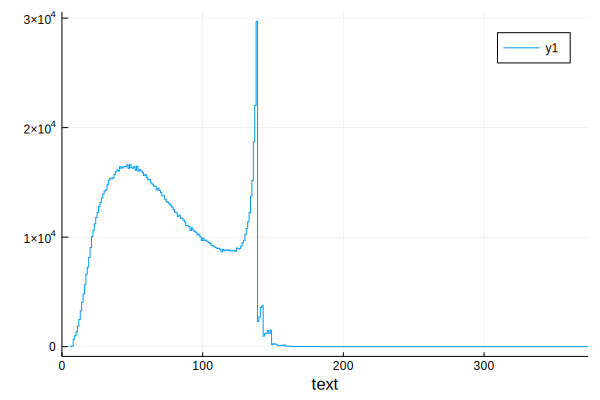

In [18]:
len_array = [length(sent) for sent in train_df.text]
plot1 = StatsPlots.histogram(len_array, xlim=(0, maximum(len_array)), xlabel="text")

In [19]:
describe(train_df.date)

Summary Stats:
Length:         1583691
Type:           DateTime
Number Unique:  769709


In [20]:
sum(nonunique(select(train_df, :user)))

929345

In [21]:
first(sort(value_counts(train_df, :user), :nrow, rev=true), 10)

,user,nrow
,String,Int64
1,lost_dog,549
2,webwoke,341
3,SallytheShizzle,281
4,VioletsCRUK,279
5,mcraddictal,274
6,tsarnick,248
7,what_bugs_u,246
8,Karen230683,237
9,DarkPiano,234


### Create text vectorizer

We create a document-term matrix with 934 tokens as follows:

In [22]:
small_train_size = 10000
small_train_df = train_df[shuffle(1:nrow(train_df))[1:small_train_size], :]

,polarity,date,user,text
,Int64,DateTime,String,String
1,1,2009-06-15T17:21:32,SAPvideoz,i watching marley and me
2,1,2009-05-17T09:56:53,attilafarkas1,"@klaudialorincz I said that song is incredible, didnt I ??!!! ha"
3,0,2009-06-07T19:33:15,MissVictoriaLj,Just got done playin putt putt!! Wish I could get good at this!!!
4,1,2009-06-05T10:45:32,ASchreiber,"@sdgross do you smell? if not you probly arent a shitty friend, if so, that could be why"
5,0,2009-05-31T23:37:50,Avi_Cado,"@VonQuale they're assessin her mental health. guess she had a nervous breakdown. they didn't strap her to a gurney, though. poor subo."
6,1,2009-06-15T14:53:46,Aggiecowgirl15,@NickkkJonasss Any way to win free tickets to your arlinton concert? it's the only one I can make... Unfortunately... No $ :/
7,0,2009-06-05T10:13:49,moondreams87,"@NathanFillion Awww Bad timing, it's been warm lately. Hopefully it will pick up, or maybe we'll bring along some whisky to warm you up!"
8,1,2009-06-06T01:56:19,pluincee,"i dreamt i stole a bus to get the bags on it back to @dearoldhouse..ended up in less than desireable situation, still fun though"
9,0,2009-06-07T09:53:06,mustBeButta,I did sneak and drive my car and got yelled at


In [23]:
count_transformer = CountTransformer()
mach = machine(count_transformer, tokenize.(small_train_df.text))
MLJ.fit!(mach)

┌ Info: Training Machine{CountTransformer,…}.
└ @ MLJBase C:\Users\Amirreza\.julia\packages\MLJBase\QXObv\src\machines.jl:403


Machine{CountTransformer,…} trained 1 time; caches data
  args: 
    1:	Source @821 ⏎ `AbstractVector{AbstractVector{Textual}}`


In [24]:
small_train_dtm = MLJ.transform(mach, tokenize.(small_train_df.text))

10000×24380 adjoint(::SparseArrays.SparseMatrixCSC{Int64, Int64}) with eltype Int64:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 3  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 5  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  2  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  1  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  2  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  3  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  1  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  0  0 

In [25]:
test_dtm = MLJ.transform(mach, tokenize.(test_df.text))

498×24380 adjoint(::SparseArrays.SparseMatrixCSC{Int64, Int64}) with eltype Int64:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 3  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 2  0  0  0  0  0  0  0  2  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  0  0  0

### Naive Bayes Classifier using TextAnalysis

In [26]:
classes = unique(small_train_df.polarity)
nbc = NaiveBayesClassifier(classes)

NaiveBayesClassifier{Int64}(String[], [1, 0], Matrix{Int64}(undef, 0, 2))

In [27]:
for (text, polarity) in zip(small_train_df.text, small_train_df.polarity)
    TextAnalysis.fit!(nbc, text, polarity)
end

In [28]:
nbc

NaiveBayesClassifier{Int64}(["watching", "me", "marley", "and", "i", "!", "is", "incredible", ",", "song"  …  "whites", "kraft", "HungryGirl", "Lauraaa", "Chatting", "Alishaaa", "modern", "vieirasboots", "sapiens", "evolution"], [1, 0], [66 57; 400 523; … ; 1 2; 1 2])

In [29]:
function get_prediction(probability_dict)
    if (probability_dict[0] > probability_dict[1])
        return 0
    else
        return 1
    end
end

test_df[:, :predictions] = [get_prediction(TextAnalysis.predict(nbc, text)) for text in test_df.text]
DataFrames.show(test_df, allcols=true)

498×5 DataFrame
 Row │ polarity  date                 user             text                               predictions 
     │ Int64     DateTime             String           String                             Int64       
─────┼────────────────────────────────────────────────────────────────────────────────────────────────
   1 │        1  2009-05-11T03:17:40  tpryan           @stellargirl I loooooooovvvvvvee…            0
   2 │        1  2009-05-11T03:18:03  vcu451           Reading my kindle2...  Love it..…            1
   3 │        1  2009-05-11T03:18:54  chadfu           Ok, first assesment of the #kind…            0
   4 │        1  2009-05-11T03:19:04  SIX15            @kenburbary You'll love your Kin…            1
   5 │        1  2009-05-11T03:21:41  yamarama         @mikefish  Fair enough. But i ha…            0
   6 │        1  2009-05-11T03:22:00  GeorgeVHulme     @richardebaker no. it is too big…            0
   7 │        0  2009-05-11T03:22:30  Seth937          Fuck thi

### Naive Bayes using sklearn

In [30]:
vectorizer = CountVectorizer(min_df=0.001, max_df=0.8, stop_words="english")
train_dtm = vectorizer.fit_transform(train_df.text)

PyObject <1583691x941 sparse matrix of type '<class 'numpy.int64'>'
	with 6472189 stored elements in Compressed Sparse Row format>

In [31]:
train_dtm

PyObject <1583691x941 sparse matrix of type '<class 'numpy.int64'>'
	with 6472189 stored elements in Compressed Sparse Row format>

In [32]:
test_dtm = vectorizer.transform(test_df.text)

PyObject <498x941 sparse matrix of type '<class 'numpy.int64'>'
	with 2042 stored elements in Compressed Sparse Row format>

In [33]:
nb = MultinomialNB()
nb.fit(train_dtm, train_df.polarity)
#nb.fit(small_train_dtm, small_train_df.polarity)

PyObject MultinomialNB()

### Predict Test Polarity

In [34]:
predicted_polarity = nb.predict(test_dtm)

498-element Vector{Int64}:
 1
 1
 0
 1
 1
 1
 0
 1
 1
 1
 1
 0
 1
 ⋮
 1
 1
 1
 1
 0
 1
 1
 1
 0
 1
 0
 0

### Evaluate Results

In [35]:
accuracy_score(test_df.polarity, predicted_polarity)

0.7911646586345381

### TextBlob for Sentiment Analysis

In [36]:
#Conda.add("textblob")

In [37]:
@pyimport textblob

In [38]:
sample_positive = train_df[1500000, :text]
sample_polarity = train_df[1500000, :polarity]
println(sample_positive)
println(sample_polarity)

rocked english and german; only economics left! Enjoying this  
1


In [39]:
parsed_positive = textblob.TextBlob(sample_positive)
parsed_positive.polarity

0.1

In [40]:
sample_negative = train_df[250000, :text]
sample_polarity = train_df[250000, :polarity]
println(sample_negative)
println(sample_polarity)

@moonfrye Up here in CANADA ... you would have your butt kicked for that!  How awful.  
0


In [41]:
parsed_negative = textblob.TextBlob(sample_negative)
parsed_negative.polarity

-1.0

In [42]:
function estimate_polarity(text)
    return textblob.TextBlob(text).sentiment[1]
end

estimate_polarity (generic function with 1 method)

In [43]:
sample_train = select(train_df[shuffle(1:nrow(train_df))[1:10], :], [:polarity, :text])
sample_train[!, :sentiment] = estimate_polarity.(sample_train.text)
sort!(sample_train, :sentiment, rev=true)
DataFrames.show(sample_train, allcols=true)

10×3 DataFrame
 Row │ polarity  text                               sentiment 
     │ Int64     String                             Float64   
─────┼────────────────────────────────────────────────────────
   1 │        1  just had breakfast @ toast with …   0.85
   2 │        1  @JustinJohnJacob Awesomeee, now …   0.5
   3 │        0  @FrakFraco It wont let me DM you…   0.266667
   4 │        1  @ShrimpSalad Thanks and it proba…   0.2125
   5 │        1  Waiting for a new T.V               0.136364
   6 │        0  the forums were gone..  oh well.…   0.0
   7 │        1  Send me a pic of your charter  b…   0.0
   8 │        1  @emilyjane_elrod you should go t…   0.0
   9 │        0  I need help? What do you say to …   0.0
  10 │        0  Just got shots at the doctor!  T…  -0.875

### Compare with TextBlob Polarity Score

We also obtain TextBlob sentiment scores for the tweets and note (see left panel in below figure) that positive test tweets receive a significantly higher sentiment estimate. We then use the MultinomialNB ‘s model .predict_proba() method to compute predicted probabilities and compare both models using the respective Area Under the Curve (see right panel below).

In [44]:
test_df[:, :sentiment] = [estimate_polarity(text) for text in test_df.text]
DataFrames.show(first(test_df, 5), allcols=true)

5×6 DataFrame
 Row │ polarity  date                 user      text                               predictions  sentiment  
     │ Int64     DateTime             String    String                             Int64        Float64    
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │        1  2009-05-11T03:17:40  tpryan    @stellargirl I loooooooovvvvvvee…            0   0.408929
   2 │        1  2009-05-11T03:18:03  vcu451    Reading my kindle2...  Love it..…            1   0.6
   3 │        1  2009-05-11T03:18:54  chadfu    Ok, first assesment of the #kind…            0  -0.0833333
   4 │        1  2009-05-11T03:19:04  SIX15     @kenburbary You'll love your Kin…            1   0.223052
   5 │        1  2009-05-11T03:21:41  yamarama  @mikefish  Fair enough. But i ha…            0   0.55

In [45]:
function polarity_from_sentiment(sentiment)
    if (sentiment > 0)
        return 1
    else
        return 0
    end
end

predicted_polarity = [polarity_from_sentiment(sentiment) for sentiment in test_df.sentiment]

498-element Vector{Int64}:
 1
 1
 0
 1
 1
 1
 0
 1
 0
 0
 0
 0
 0
 ⋮
 0
 1
 0
 1
 1
 1
 0
 0
 0
 1
 0
 0

In [46]:
accuracy_score(test_df.polarity, predicted_polarity)

0.6104417670682731

#### ROC AUC Scores

In [47]:
roc_auc_score(y_true = test_df.polarity, y_score = test_df.sentiment)

0.7424802435890666

In [48]:
roc_auc_score(y_true = test_df.polarity, y_score = nb.predict_proba(test_dtm)[:, 1])

0.15176795677350088

In [49]:
fpr_tb, tpr_tb, _ = roc_curve(y_true = test_df.polarity, y_score = test_df.sentiment)
roc_tb = DataFrame(index = fpr_tb, tpr_tb = tpr_tb)

,index,tpr_tb
,Float64,Float64
1,0.0,0.0
2,0.0112994,0.0404984
3,0.0112994,0.0560748
4,0.0225989,0.0685358
5,0.0225989,0.0809969
6,0.0282486,0.0809969
7,0.0282486,0.0872274
8,0.039548,0.11838
9,0.039548,0.121495


In [50]:
fpr_nb, tpr_nb, _ = roc_curve(y_true = test_df.polarity, y_score = nb.predict_proba(test_dtm)[:, 2])
roc_nb = DataFrame(index = fpr_nb, tpr_nb = tpr_nb)

,index,tpr_nb
,Float64,Float64
1,0.0,0.0
2,0.0,0.00311526
3,0.0,0.0342679
4,0.00564972,0.0342679
5,0.00564972,0.0498442
6,0.00564972,0.0560748
7,0.00564972,0.0716511
8,0.0112994,0.0716511
9,0.0112994,0.130841


The Naive Bayes model outperforms TextBlob in this case.

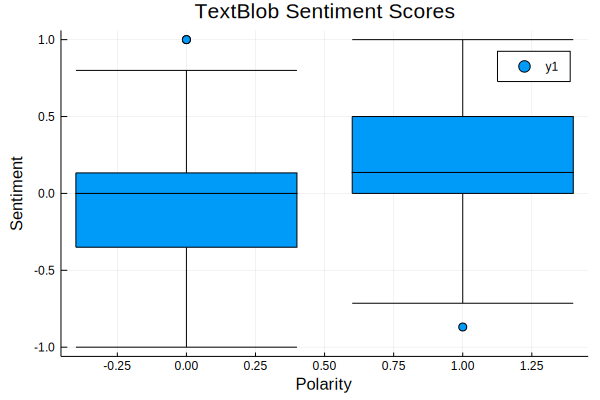

In [51]:
plot1 = StatsPlots.boxplot(test_df.polarity, test_df.sentiment)
xlabel!("Polarity")
ylabel!("Sentiment")
StatsPlots.title!("TextBlob Sentiment Scores")

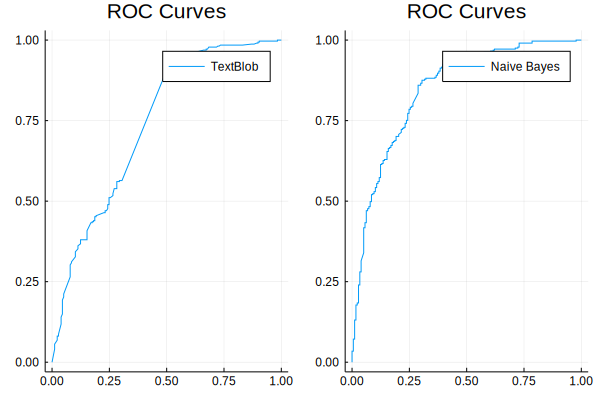

In [52]:
plot1 = StatsPlots.plot(roc_tb.index, roc_tb.tpr_tb, label="TextBlob")
plot2 = StatsPlots.plot(roc_nb.index, roc_nb.tpr_nb, label="Naive Bayes")
StatsPlots.plot(plot1, plot2, title="ROC Curves")